In [159]:
#Import libraries and functions

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import glob #pattern package to find filename
from skimage.io import imread
from scipy import ndimage
from scipy.ndimage import shift
from scipy.ndimage.measurements import center_of_mass
from scipy.ndimage.interpolation import rotate
from scipy.optimize import curve_fit

In [160]:
##Some constants

kb = 8.62e-2 #in units of meV/K

In [161]:
#Material-specific lattice parameters (in angstrom)

a = 4.36138
c = 40.92263

lattice_para = np.array([[a, 0, 0], [a*np.cos(2*np.pi/3), a*np.sin(2*np.pi/3), 0], [0, 0, c]])

ra = 4*np.pi/(np.sqrt(3)*a)
rc = 2*np.pi/c

rec_lattice_para = np.array([[ra*np.cos(np.pi/6), ra*np.sin(np.pi/6), 0], [ra*np.cos(5*np.pi/6), ra*np.sin(5*np.pi/6), 0], [0, 0, rc]])


In [162]:
#Importing material-specific unit cell coordinates and other parameters

##Fractional unit cell coordinates of all atoms - Mn (3), Bi (6), Te (12) = 21 atoms in hexagonal unit cell.
          
unit_r_Mn = np.array([R(0, 0, 0), R(2/3, 1/3, 1/3), R(1/3, 2/3, 2/3)])
unit_r_Bi = np.array([R(0, 0, 0.42), R(0, 0, 0.57), R(0.67, 0.33, 0.75), R(0.67, 0.33, 0.91), R(0.33, 0.67, 0.09), R(0.33, 0.67, 0.24)])
unit_r_Te = np.array([R(0, 0, 0.13), R(0, 0, 0.86), R(0.67, 0.33, 0.47), R(0.67, 0.33, 0.2), R(0.33, 0.67, 0.8), R(0.33, 0.67, 0.53), R(0, 0, 0.3), R(0, 0, 0.7), R(0.67, 0.33, 0.63), R(0.67, 0.33, 0.04), R(0.33, 0.67, 0.96), R(0.33, 0.67, 0.37)])                    

unit_r = np.concatenate((unit_r_Mn, unit_r_Bi, unit_r_Te), axis = 0)

##Importing Debye-Waller information

B_Mn = 0.05*np.ones(3)
B_Bi = 0.05*np.ones(6)
B_Te = 0.05*np.ones(12)

B = np.concatenate((B_Mn, B_Bi, B_Te), axis = 0)

##Importing atomic structure factor information - for now just assuming constants, ignoring the Q-dependence.

f_Mn = np.ones(3)
f_Bi = np.ones(6)
f_Te = np.ones(12)

f = np.concatenate((f_Mn, f_Bi, f_Te), axis = 0)

##Importing atomic mass information

m_Mn = np.ones(3)
m_Bi = np.ones(6)
m_Te = np.ones(12)

m = np.concatenate((m_Mn, m_Bi, m_Te), axis = 0)

In [163]:
#Defining some functions

##Functions that return Q, K, and q for a given h, k, l, in units of A^-1

def Q(h, k, l):
    return h*rec_lattice_para[0] + k*rec_lattice_para[1] + l*rec_lattice_para[2]

def K(h, k, l):
    d_test = 10 #this will store the minimum norm for comparison (10 is just an arbitrary number)
    m_test = 1 #this will store the integer m corresponding to minimum norm
    n_test = 1 #this will store the integer n corresponding to minimum norm
    for m in np.arange(np.rint(h)-2, np.rint(h)+2, 1):
        for n in np.arange(np.rint(k)-2, np.rint(k)+2, 1):
            d = (h - m)**2 + (k - n)**2 - (h - m)*(k - n)
            if d < d_test:
                d_test = d
                m_test = m
                n_test = n
    #print(d_test)
    #print(m_test)
    #print(n_test)
    return m_test*rec_lattice_para[0] + n_test*rec_lattice_para[1] + np.rint(l)*rec_lattice_para[2]
            
def q(h, k, l):
    return Q(h, k, l) - K(h, k, l) 

##Function that returns r = xa + yb + zc for a given x, y, z, in units of A

def R(x, y, z):
    return x*lattice_para[0] + y*lattice_para[1] + z*lattice_para[2]

##Exception for division by zero

def div(n, d):
    return n/d if d > 0.15 else 0

##Boltzmann statistics function
##This is for the given phonon dispersion relation
def n(h, k, l):
    return np.exp(-w(h, k, l)/(kb*T))

In [173]:
#Material-specific physical parameters. For now, we use functional forms for everything.

##Phonon energy as a function of h, k, l, assuming linear dispersion of an acoustic phonon. This is in units of meV.
##Normalized such that the highest phonon energy (at zone boundary) is 5 meV ~ 1 THz.

def w(h, k, l):
#     return 5*(np.linalg.norm(q(h, k, l)))/np.linalg.norm(Q(0.5, 0.5, 0.5)) 
    return 4

##Transverse acoustic phonon eigenvector

def e_t(h, k, l):
    e_t_temp = np.cross(q(h, k, l), [0, 0, 1]) #To find the direction perpendicular to a phonon wavevector in the xy plane.
    if np.linalg.norm(e_t_temp) != 0: #Avoiding division by zero.
        return e_t_temp/np.linalg.norm(e_t_temp)
    else:
        return e_t_temp

##Longitudinal acoustic phonon eigenvector

def e_l(h, k, l):
    e_l_temp = q(h, k, l)
    if np.linalg.norm(e_l_temp) != 0: #Avoiding division by zero.
        return e_l_temp/np.linalg.norm(e_l_temp)
    else:
        return e_l_temp    
    
##An example optical phonon eigenvector, at the Gamma point
##This is listed in the order that Nathan's output is listed, with a 7-atom unit cell

eVector_nathan = np.array([R(0,0,0), R(-0.16, -0.44, 0), R(0.16, 0.44, 0), R(-0.13, 0.33, 0), R(0.13, 0.33, 0), R(0.14, 0.36, 0), R(-0.14, -0.36, 0)])

eVector_Mn = np.array([eVector_nathan[0], eVector_nathan[0], eVector_nathan[0]])
eVector_Te = np.array([eVector_nathan[2], eVector_nathan[2], eVector_nathan[1], eVector_nathan[1], eVector_nathan[1], eVector_nathan[1]])
eVector_Bi = np.array([eVector_nathan[6], eVector_nathan[6], eVector_nathan[3], eVector_nathan[3],
                      eVector_nathan[5], eVector_nathan[5], eVector_nathan[6], eVector_nathan[6],
                      eVector_nathan[3], eVector_nathan[3], eVector_nathan[5], eVector_nathan[5]]) 

eVector = np.concatenate((eVector_Mn, eVector_Bi, eVector_Te), axis = 0)

In [174]:
#Function that outputs the structure factor, taking as inputs the (h, k, l), DW factor B, and unit cell r.
##This is only for acoustic phonons, so the eigenvector is the same for all atoms.

def F(h, k, l, f, m, B, r):
    f_sum = 0
    for i in np.arange(0, np.shape(r)[0]): #sum over all the atoms in unit cell
#         f_sum = f_sum + (f[i]/m[i]**0.5)*np.exp(-B[i]*(np.linalg.norm(Q(h, k, l))**2))*np.dot(Q(h, k, l), e_t(h, k, l))*np.exp(-1j*np.dot(K(h, k, l), r[i]))
        f_sum = f_sum + (f[i]/m[i]**0.5)*np.exp(-B[i]*(np.linalg.norm(Q(h, k, l))**2))*np.dot(Q(h, k, l), eVector[i])*np.exp(-1j*np.dot(K(h, k, l), r[i]))

    return f_sum    

In [175]:
##Select atoms of unit cell to analyze

# unit_r = unit_r_Mn
# B = B_Mn
# m = m_Mn

In [176]:
h_i = -5
h_f = 5
k_i = -5
k_f = 5

##Create arrays with x, y for integer h, k, l

data_int = np.zeros(((h_f-h_i)*(k_f-k_i),3))

i = 0

for h in np.arange(h_i, h_f, 1):
    for k in np.arange(k_i, k_f, 1):
        
        data_int[i] = [Q(h, k, 0)[0], Q(h, k, 0)[1], 0]
        #print(data_int[i])
        i = i + 1
        
x_int = data_int[:,0]
y_int = data_int[:,1]

##Create arrays with x, y for integer h, k, l satisfying Bragg condition

data_int_bragg = np.zeros(((h_f-h_i)*(k_f-k_i),3))

i = 0

for h in np.arange(h_i, h_f, 1):
    for k in np.arange(k_i, k_f, 1):
        
        ###Sum over phase factors to check for selection rule
        temp_sum = 0
        for j in np.arange(0, np.shape(unit_r)[0]): #sum over all the atoms in unit cell
            temp_sum = temp_sum + np.exp(-1j*np.dot(K(h, k, 0), unit_r[j]))
            
        #print(temp_sum) #to debug forbidden Bragg peaks
        
        if np.abs(temp_sum) > 10:
            data_int_bragg[i] = [Q(h, k, 0)[0], Q(h, k, 0)[1], 0]
            #print(data_int[i])
        i = i + 1

x_int_bragg = data_int_bragg[:,0]
y_int_bragg = data_int_bragg[:,1]

<IPython.core.display.Javascript object>


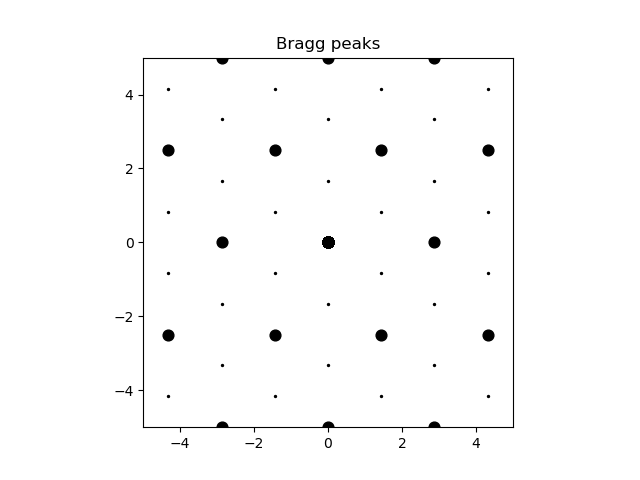

Text(0.5, 1.0, 'Bragg peaks')

In [177]:
##Plot Bragg peaks

fig1, ax1 = plt.subplots()

ax1.scatter(x_int, y_int, s = 2, color = 'k') #all reciprocal lattice vectors
ax1.scatter(x_int_bragg, y_int_bragg, s = 60, color = 'k') #only Bragg peaks

plt.xlim(-5,5)
plt.ylim(-5,5)

ax1.set_aspect('equal')
ax1.set_title('Bragg peaks')

In [178]:
##Create mesh of diffuse scattering intensity data for entire scattering space

T = 300 #in units of K

mesh = 200

data = np.zeros((mesh*mesh,3))

i = 0

for h in np.arange(h_i, h_f, (h_f-h_i)/mesh):
    for k in np.arange(k_i, k_f, (k_f-k_i)/mesh):
        data[i] = [Q(h, k, 0)[0], Q(h, k, 0)[1], 0] 
        data[i,2] = (n(h, k, 0) + 0.5)*div((np.abs(F(h, k, 0, f, m, B, unit_r)))**2, w(h, k, 0))

        i = i + 1

x = data[:,0]
y = data[:,1]
z = data[:,2]

<IPython.core.display.Javascript object>


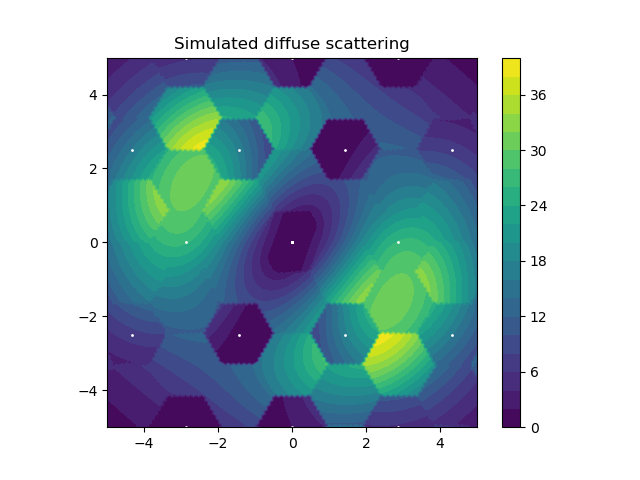

Text(0.5, 1.0, 'Simulated diffuse scattering')

In [179]:
##Plot total intensity

fig2, ax2 = plt.subplots()

tcf = ax2.tricontourf(x, y, z, levels = 20)
plt.colorbar(tcf)

#tcf.set_clim(0, 15)

plt.xlim(-5,5)
plt.ylim(-5,5)

##Plot Bragg peaks

ax2.scatter(x_int_bragg, y_int_bragg, s = 1, color = 'w')

ax2.set_aspect('equal')
ax2.set_title('Simulated diffuse scattering')

In [158]:
print(z)

[0. 0. 0. ... 0. 0. 0.]
